Preparación del entorno

In [1]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from envs.multi_step_limited_attack_env import AttackEnvLimitedMultiStep
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import numpy as np
import joblib
from stable_baselines3 import SAC
from stable_baselines3 import PPO

Funciones Auxiliares

In [10]:
# Clase callback personalizada para logear y graficar
class AttackLoggerCallback(BaseCallback): # Extiende BaseCallback de stable-baselines3

    def __init__(self, log_freq: int = 1000, verbose: int = 0): # Muestra estadísticas cada 1000 episodios y pone el nivel de verbosidad a 0 por defecto (no muestra nada)
        super().__init__(verbose) # Llamamos al constructor padre con el nivel de verbosidad
        self.log_freq = log_freq # Muestra estadísticas cada log_freq episodios
        self.episode_count = 0 # Contador de episodios completados

        # Buffers por ventana (1000 episodios)
        self.rewards_buffer = [] # Buffer para recompensas
        self.success_buffer = [] # Buffer de veces que tuvo éxito
        self.p_attack_buffer = [] # Buffer de probabilidades de que el detector detecte el ataque
        self.dist_buffer = [] # Buffer de distancias entre x_adv y x_orig (tamaño de la perturbación)

        # Históricos completos para graficar
        self.history_episodes = []
        self.history_mean_reward = []
        self.history_success_rate = []
        self.history_mean_p_attack = []
        self.history_mean_dist = [] # Historial de distancia media por ventana

    def _on_step(self) -> bool:

        # Extraemos la información relevante del entorno
        infos = self.locals["infos"] # Información devuelta por el entorno
        rewards = self.locals["rewards"] # Recompensas obtenidas
        dones = self.locals["dones"] # Si el episodio ha terminado

        # Iteramos sobre la información, recompensas y estados de finalización
        for info, r, done in zip(infos, rewards, dones):

            # Si el episodio ha terminado
            if done:
                self.episode_count += 1 #  Incrementamos el contador de episodios
                self.rewards_buffer.append(float(r)) # Guardamos la recompensa obtenida

                # Si hubo éxito en el ataque
                if "success" in info:
                    self.success_buffer.append(int(info["success"])) # Guardamos si tuvo éxito

                # Si se proporciona la probabilidad de detección del ataque
                if "p_attack" in info:
                    self.p_attack_buffer.append(float(info["p_attack"])) # Guardamos la probabilidad de detección del ataque

                # Si se proporciona la distancia entre x_adv y x_orig
                if "dist" in info:
                    self.dist_buffer.append(float(info["dist"])) # Guardamos la distancia (magnitud de la perturbación)

                # Cada log_freq episodios, mostramos las estadísticas
                if self.episode_count > 0 and self.episode_count % self.log_freq == 0:

                    # Calculamos las métricas
                    mean_reward = np.mean(self.rewards_buffer) if self.rewards_buffer else 0.0 # Recompensa media
                    success_rate = np.mean(self.success_buffer) if self.success_buffer else 0.0 # Tasa de éxito
                    mean_p_attack = np.mean(self.p_attack_buffer) if self.p_attack_buffer else 0.0 # Probabilidad media de detección del ataque
                    mean_dist = np.mean(self.dist_buffer) if self.dist_buffer else 0.0 # Distancia media (tamaño medio de la perturbación)

                    # Guardamos las métricas en el histórico
                    self.history_episodes.append(self.episode_count) # Episodios completados
                    self.history_mean_reward.append(mean_reward) # Recompensa media
                    self.history_success_rate.append(success_rate) # Tasa de éxito
                    self.history_mean_p_attack.append(mean_p_attack) # Probabilidad media de detección del ataque
                    self.history_mean_dist.append(mean_dist) # Distancia media de la perturbación

                    # Mostramos las métricas por consola
                    print(
                        f"[AttackLogger] Episodios: {self.episode_count:6d} | "
                        f"Reward medio: {mean_reward: .3f} | "
                        f"Tasa éxito: {success_rate*100:5.1f}% | "
                        f"p_attack media: {mean_p_attack: .3f} | "
                        f"dist media: {mean_dist: .3f}"
                    )

                    # Limpiamos los buffers para la siguiente ventana
                    self.rewards_buffer.clear()
                    self.success_buffer.clear()
                    self.p_attack_buffer.clear()
                    self.dist_buffer.clear()

        return True


In [22]:
# Función para evaluar el agente SAC atacante
def evaluate_sac_attacker(model, env, n_episodes=500): # Evalúa el agente en el entorno dado durante n_episodes episodios
    
    # Variables para recuento
    successes = 0 # Contador de episodios exitosos
    total_steps = 0 # Contador de pasos totales
    final_p_attacks = [] # Lista para almacenar las probabilidades de que el ataque modificado sea detectado como ataque
    final_dists = [] # Lista para almacenar la distancia final entre x_adv y x_orig (tamaño de la perturbación)

    # Reseteamos el entorno
    obs = env.reset()

    # Iteramos por el numero de episodios a evaluar
    for _ in range(n_episodes):

        # Variables de control de finalización del episodio
        done = False
        truncated = False

        # Mientras no se termine el episodio
        while not (done or truncated):

            # Obtenemos la acción del modelo (determinística, ahora queremos el mejor ataque posible no explorar)
            action, _ = model.predict(obs, deterministic=True)

            # Ejecutamos la acción en el entorno y obtenemos los resultados
            obs, reward, done, info = env.step(action)

            # Cogemos el primer diccionario de info (entorno vectorizado, solo hay uno)
            info0 = info[0]

            # Parche para gym
            truncated = info0.get("terminal_observation") is not None if False else False  

            # Incrementamos el contador de pasos
            total_steps += 1

            # Si el valor de step_count es igual a max_steps del entorno
            if info0.get("step_count", 0) == env.get_attr("max_steps")[0]: 

                # Si el detector no detecta el ataque (pred = 0)
                if info0["pred"] == 0: 
                    successes += 1 # Incrementamos el contador de éxitos

                # Guardamos la probabilidad de que el defensor detecte el ataque modificado por el agente como ataque
                final_p_attacks.append(info0["p_attack"])

                # Guardamos la distancia final entre x_adv y x_orig
                if "dist" in info0:
                    final_dists.append(info0["dist"])

        # Reseteamos el entorno para el siguiente episodio
        obs = env.reset()

    # Calculamos las métricas finales
    success_rate = successes / n_episodes # Tasa de éxito, número de episodios exitosos dividido por el total de episodios
    mean_final_p = float(np.mean(final_p_attacks)) if final_p_attacks else None # Probabilidad media final de ataque
    mean_final_dist = float(np.mean(final_dists)) if final_dists else None # Distancia media final de la perturbación

    # Devolvemos las métricas
    return success_rate, mean_final_p, mean_final_dist


In [12]:
# Función para muestrear ataques adversariales completos (multi-step)
def sample_adversarials_multistep(model, env, n_episodes=200): # Agente SAC, entorno de ataque multi-step, número de episodios a muestrear

    # Listas para almacenar los ataques originales, finales y éxitos
    xs_orig = []
    xs_final = []
    successes = []
    dists = []  # Lista para almacenar la distancia final entre x_adv y x_orig

    # Reseteamos el entorno para el primer episodio
    obs = env.reset()

    # Obtenemos el número máximo de pasos por episodio del entorno
    max_steps = env.get_attr("max_steps")[0]

    # Iteramos por el número de episodios a muestrear
    for _ in range(n_episodes):

        # Variables de control de finalización del episodio
        done = False
        truncated = False
        
        # Variable para almacenar el ataque original del episodio
        x_orig_ep = None

        # Mientras no se termine el episodio
        while not (done or truncated):

            # Obtenemos la acción del agente (determinística)
            action, _ = model.predict(obs, deterministic=True)

            # Ejecutamos la acción en el entorno y obtenemos los resultados
            obs, rewards, dones, infos = env.step(action)

            # Cogemos la información del primer entorno (vectorizado, solo hay uno)
            info0 = infos[0]
            done = dones[0]

            # Guardamos el ataque original (es el del primer paso del episodio)
            if x_orig_ep is None and "x_orig" in info0:
                x_orig_ep = info0["x_orig"]

            # Detectar último paso del episodio
            step_count = info0.get("step_count", 0)
            is_last = (step_count == max_steps) or done

            # Si es el último paso del episodio
            if is_last:
                
                # Guardamos el ataque adversarial final
                x_adv_final = info0["x_adv"]

                # Guardamos si el ataque logró evadir el detector (pred = 0)
                pred_final = info0["pred"]  # 0 = normal, 1 = ataque

                # Almacenamos los resultados
                xs_orig.append(x_orig_ep)
                xs_final.append(x_adv_final)
                successes.append(1 if pred_final == 0 else 0)

                # Guardamos la distancia final si está disponible
                if "dist" in info0:
                    dists.append(info0["dist"])

                break

        # Siguiente episodio
        obs = env.reset()

    # Devolvemos los ataques originales, finales, éxitos y distancias como arrays de numpy
    return np.array(xs_orig), np.array(xs_final), np.array(successes), np.array(dists)


Creación del área de trabajo

In [13]:
# Carga del dataset
data = np.load("../data/synthetic_2d.npz")
X_train, X_test = data["X_train"], data["X_test"]
y_train, y_test = data["y_train"], data["y_test"]

# Cargamos solo muestras de ataque para el entorno
attack_mask = y_train == 1 # Crea un array booleano a true para muestras de ataque
attack_samples = X_train[attack_mask] # Nos quedamos solo con las muestras de ataque

# Carga del modelo clasificador
clf = joblib.load("../classifiers/logreg_synthetic_2d.joblib")

# Imprimimos la forma de las muestras de ataque
print("Attack samples:", attack_samples.shape)

Attack samples: (800, 2)


In [14]:
# Función para crear el entorno
def make_env():
    return AttackEnvLimitedMultiStep(
        attack_samples=attack_samples, # Lista de todas las muestras de ataque
        clf=clf, # Modelo clasificador
        threshold=0.5, # A partid de de esta probabilidad se considera que es ataque
        epsilon=0.7,   # Distancia máxima que el agente puede mofificar el punto original, aumentamos un poco
        penalty=0.01,  # Penalización suave por tamaño de la perturbación
        max_steps=5,   # 5 movimientos por ataque
    )

# Creamos el entorno vectorizado
venv = DummyVecEnv([make_env])

# Normalizamos las observaciones del entorno    
venv = VecNormalize(venv, norm_obs=True, norm_reward=False) # SAC trabaja mejor con observaciones normalizadas (entre 0 y 1)

Entrenamiento del agente SAC

In [15]:
# Architectura de la red neuronal del actor y crítico
policy_kwargs = dict(net_arch=[256, 256])

model = SAC(
    "MlpPolicy", # Redes totamente conectadas (MLP)
    venv, # Entorno vectorizado y normalizado
    verbose=0, # No muestra información durante el entrenamiento
    policy_kwargs=policy_kwargs, # Arquitectura de la red neuronal
    buffer_size=200_000, # SAC es off-policy y usa un buffer de replay para almacenar experiencias pasadas y aprender de ellas, cada train_freq aprende batch_size pasos aleatorios del buffer
    learning_rate=3e-4, # Tasa de aprendizaje, qué tanto se actualizan los pesos de la red neuronal en cada paso
    batch_size=256, # Los grupos en los que se divide cada actualización
    tau=0.02, # Velocidad de actualización de la red objetivo (Como el critico se actualiza en función del actor, valor pequeno significa actualizaciones lentas)(Actor decide que acciones tomar, critico evalua esas accionees)
    train_freq=1, # Cada cuántos pasos de entorno se realiza una actualización del modelo
    gradient_steps=1, # Número de actualizaciones del modelo por cada paso de entorno
)

# Creación del callback personalizado para logging
callback = AttackLoggerCallback(log_freq=100)

# Entrenamiento del agente SAC con 10,000 timesteps y el callback
model.learn(total_timesteps=100_000, callback=callback)

# Guardamos el modelo entrenado y el entorno normalizado (SAC aprendio de un entorno normalizado, lo necesita para predecir)
model.save("../agents/sac_attacker_limited_multistep")
venv.save("../agents/sac_attacker_limited_multistep_vecnorm.pkl")

[AttackLogger] Episodios:    100 | Reward medio:  0.032 | Tasa éxito:   5.0% | p_attack media:  0.933 | dist media:  0.785
[AttackLogger] Episodios:    200 | Reward medio:  0.044 | Tasa éxito:   5.0% | p_attack media:  0.947 | dist media:  0.841
[AttackLogger] Episodios:    300 | Reward medio:  0.017 | Tasa éxito:   3.0% | p_attack media:  0.929 | dist media:  0.836
[AttackLogger] Episodios:    400 | Reward medio:  0.086 | Tasa éxito:   8.0% | p_attack media:  0.889 | dist media:  0.883
[AttackLogger] Episodios:    500 | Reward medio:  0.123 | Tasa éxito:  11.0% | p_attack media:  0.875 | dist media:  0.909
[AttackLogger] Episodios:    600 | Reward medio:  0.141 | Tasa éxito:  13.0% | p_attack media:  0.876 | dist media:  0.896
[AttackLogger] Episodios:    700 | Reward medio:  0.108 | Tasa éxito:  11.0% | p_attack media:  0.864 | dist media:  0.934
[AttackLogger] Episodios:    800 | Reward medio:  0.085 | Tasa éxito:   9.0% | p_attack media:  0.873 | dist media:  0.958
[AttackLogger] E

Gráficas de SAC

In [16]:
# Configuración de gráficos para visualizar los resultados
plt.style.use("seaborn-v0_8-whitegrid")

# Datos para graficar
episodes = np.array(callback.history_episodes)
success_rate = np.array(callback.history_success_rate) * 100
mean_reward = np.array(callback.history_mean_reward)
mean_p_attack = np.array(callback.history_mean_p_attack)

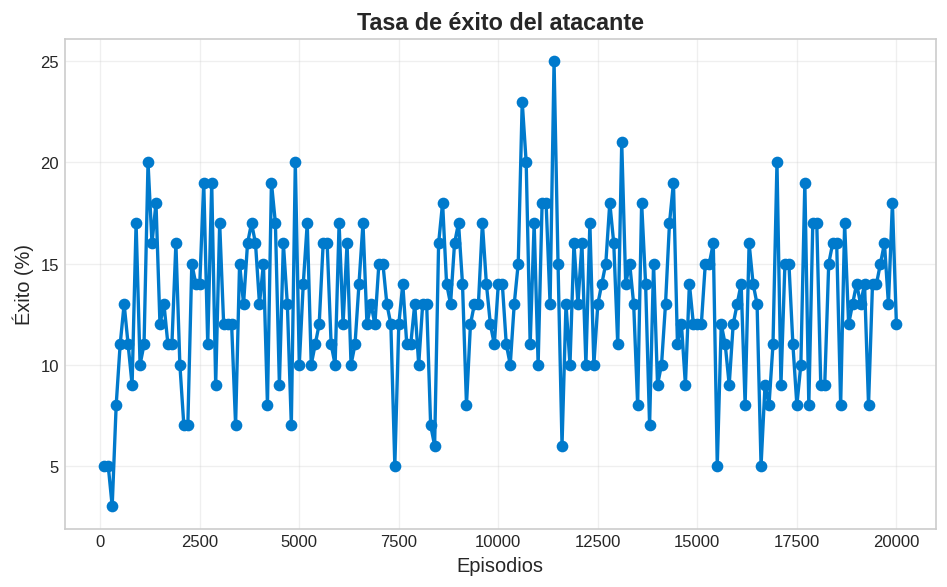

In [17]:
# Grafico de Tasa de éxito
plt.figure(figsize=(8, 5), dpi=120)
plt.plot(
    episodes,
    success_rate,
    marker="o",
    linewidth=2,
    markersize=6,
    color="#007acc",
)
plt.title("Tasa de éxito del atacante", fontsize=14, fontweight="bold")
plt.xlabel("Episodios", fontsize=12)
plt.ylabel("Éxito (%)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

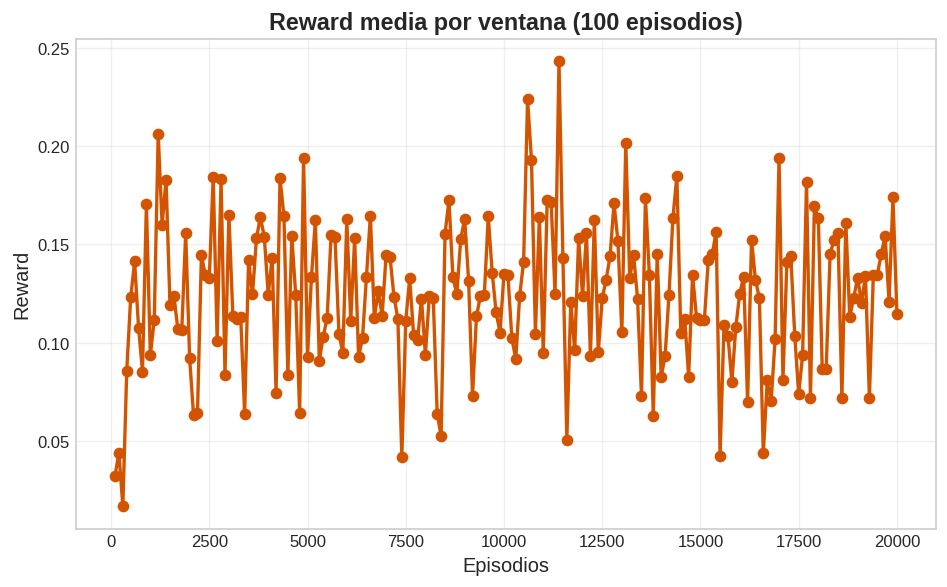

In [18]:
# Grafico de Reward media por vetana (100 episodios)
plt.figure(figsize=(8, 5), dpi=120)
plt.plot(
    episodes,
    mean_reward,
    marker="o",
    linewidth=2,
    markersize=6,
    color="#d35400",
)
plt.title("Reward media por ventana (100 episodios)", fontsize=14, fontweight="bold")
plt.xlabel("Episodios", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

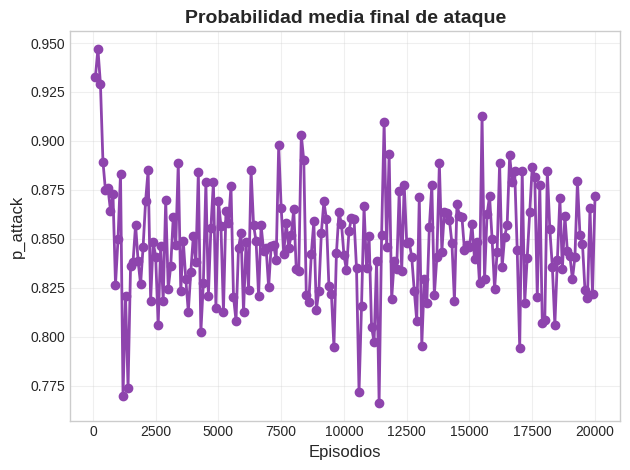

In [19]:
# Grafico de Probabilidad media final de ataque
plt.plot(
    episodes,
    mean_p_attack,
    marker="o",
    linewidth=2,
    markersize=6,
    color="#8e44ad",
)

plt.title("Probabilidad media final de ataque", fontsize=14, fontweight="bold")
plt.xlabel("Episodios", fontsize=12)
plt.ylabel("p_attack", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Evaluación de SAC

In [24]:
# Creamos un entorno vectorizado para evaluación
eval_env = DummyVecEnv([make_env])

# Cargamos la normalización del entorno usado en entrenamiento
eval_env = VecNormalize.load("../agents/sac_attacker_limited_multistep_vecnorm.pkl", eval_env)

# Desactivamos el entrenamiento, de manera que las estadísticas de normalización no se actualicen durante la evaluación 
eval_env.training = False

# Desactivamos la normalización de recompensas para la evaluación (cuando evaluamos queremos las recompensas reales)
eval_env.norm_reward = False

# Cargamos el modelo entrenado
model = SAC.load("../agents/sac_attacker_limited_multistep")

# Evaluamos el agente SAC atacante con 300 episodios
success_rate, mean_final_p, mean_final_dist = evaluate_sac_attacker(model, eval_env, n_episodes=300)

# Mostramos los resultados finales de la evaluación
print(f"Tasa de evasión (episodio completo): {success_rate*100:.3f}%")
print(f"Probabilidad media final de ataque: {mean_final_p*100:.3f}%") # La probabilidad media de que el estado modificado por el agente sea catalogado como ataque
print(f"Distancia media final de la perturbación: {mean_final_dist:.3f}") # La distancia media entre x_adv y x_orig (tamaño medio de la perturbación)

Tasa de evasión (episodio completo): 12.000%
Probabilidad media final de ataque: 86.395%
Distancia media final de la perturbación: 0.998


Conclusiones de SAC

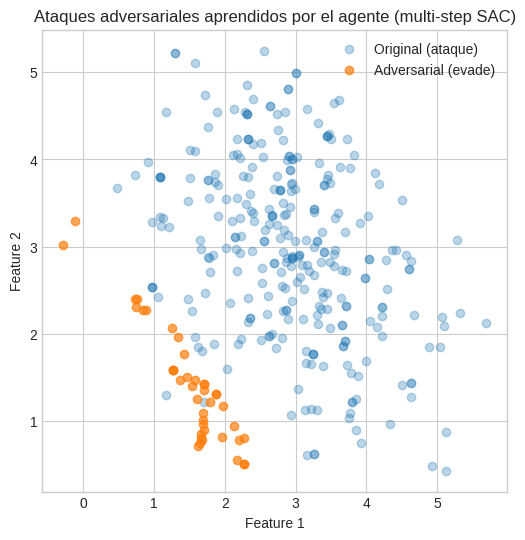

In [26]:
# Muestreamos 300 ataques adversariales generados por el agente SAC multi-step
xs_orig, xs_adv, successes, mean_final_dist = sample_adversarials_multistep(model, eval_env, n_episodes=300)

# Configuración de gráficos
plt.figure(figsize=(6, 6))

# Pintamos los ataques originales de color azul claro
plt.scatter(xs_orig[:, 0], xs_orig[:, 1], alpha=0.3, label="Original (ataque)")

# Pintamos los ataques adversariales que lograron evadir el detector de color naranja
mask_ok = successes == 1
plt.scatter(xs_adv[mask_ok, 0], xs_adv[mask_ok, 1], alpha=0.7, label="Adversarial (evade)")
plt.legend()
plt.grid(True)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Ataques adversariales aprendidos por el agente (multi-step SAC)")
plt.show()


Entrenamiento del agente PPO 

In [32]:
# Arquitectura de la red neuronal del actor y crítico (PPO también usa MLP para policy y value)
policy_kwargs = dict(net_arch=[256, 256])

# Modelo PPO
model = PPO(
    "MlpPolicy",
    venv,  # Entorno vectorizado y normalizado
    verbose=0,  # No muestra info en consola (pon 1 si quieres ver logs)
    policy_kwargs=policy_kwargs,  # Arquitectura de la red
    learning_rate=3e-4,   # Tasa de aprendizaje
    n_steps=128,          # Pasos por actualización (pequeño porque tus episodios son muy cortos)
    batch_size=64,        # Tamaño de batch para actualizar
    gamma=0.99,           # Factor de descuento
    clip_range=0.2,       # Clip de PPO
    ent_coef=0.0,         # Coeficiente de entropía (0 si no quieres forzar exploración extra)
)

# Callback de logging (el mismo que ya tienes)
callback_PPO = AttackLoggerCallback(log_freq=100)

# Entrenamiento del agente PPO
model.learn(total_timesteps=40_000, callback=callback_PPO)

# Guardamos el modelo entrenado y el entorno normalizado
model.save("../agents/ppo_attacker_multistep")
venv.save("../agents/ppo_attacker_multistep_vecnorm.pkl")


/home/javil/miniconda3/envs/tesis-roberto/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


[AttackLogger] Episodios:    100 | Reward medio:  0.162 | Tasa éxito:  15.0% | p_attack media:  0.856
[AttackLogger] Episodios:    200 | Reward medio:  0.503 | Tasa éxito:  40.0% | p_attack media:  0.607
[AttackLogger] Episodios:    300 | Reward medio:  0.350 | Tasa éxito:  29.0% | p_attack media:  0.698
[AttackLogger] Episodios:    400 | Reward medio:  0.587 | Tasa éxito:  43.0% | p_attack media:  0.567
[AttackLogger] Episodios:    500 | Reward medio:  0.709 | Tasa éxito:  56.0% | p_attack media:  0.422
[AttackLogger] Episodios:    600 | Reward medio:  0.390 | Tasa éxito:  30.0% | p_attack media:  0.666
[AttackLogger] Episodios:    700 | Reward medio:  0.714 | Tasa éxito:  55.0% | p_attack media:  0.455
[AttackLogger] Episodios:    800 | Reward medio:  0.776 | Tasa éxito:  62.0% | p_attack media:  0.385
[AttackLogger] Episodios:    900 | Reward medio:  0.989 | Tasa éxito:  82.0% | p_attack media:  0.249
[AttackLogger] Episodios:   1000 | Reward medio:  1.050 | Tasa éxito:  89.0% | p_a

In [33]:
# Configuración de gráficos para visualizar los resultados
plt.style.use("seaborn-v0_8-whitegrid")

# Datos para graficar
episodes = np.array(callback_PPO.history_episodes)
success_rate = np.array(callback_PPO.history_success_rate) * 100
mean_reward = np.array(callback_PPO.history_mean_reward)
mean_p_attack = np.array(callback_PPO.history_mean_p_attack)

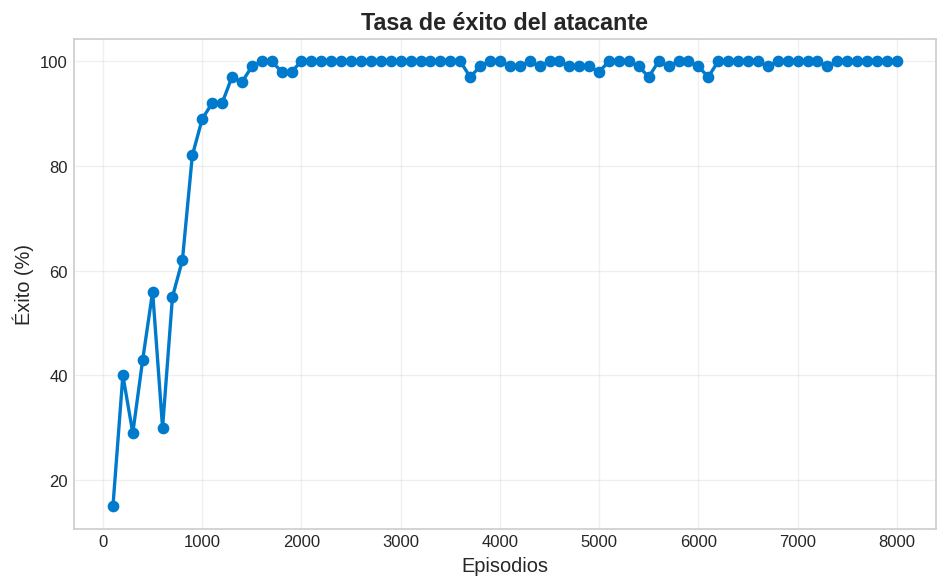

In [34]:
# Grafico de Tasa de éxito
plt.figure(figsize=(8, 5), dpi=120)
plt.plot(
    episodes,
    success_rate,
    marker="o",
    linewidth=2,
    markersize=6,
    color="#007acc",
)
plt.title("Tasa de éxito del atacante", fontsize=14, fontweight="bold")
plt.xlabel("Episodios", fontsize=12)
plt.ylabel("Éxito (%)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

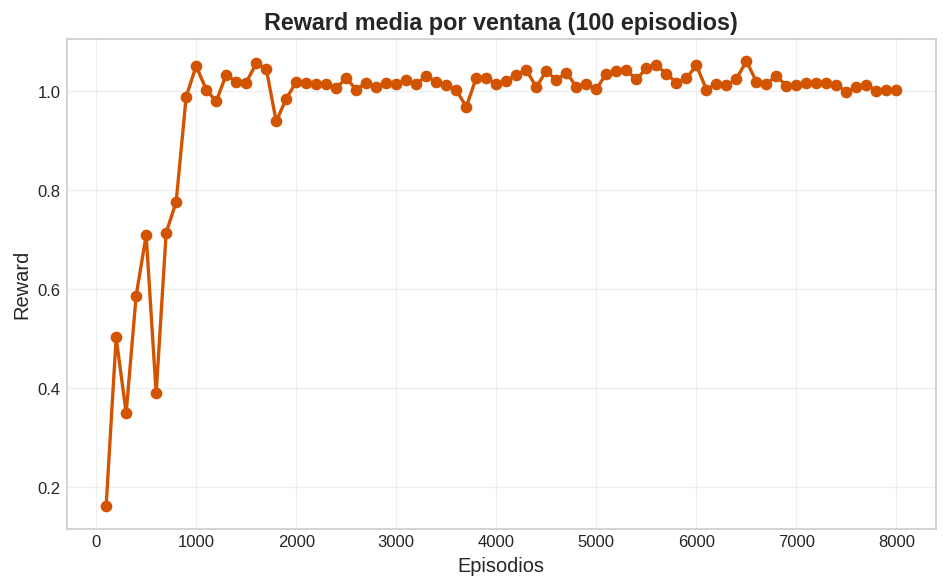

In [35]:
# Grafico de Reward media por vetana (100 episodios)
plt.figure(figsize=(8, 5), dpi=120)
plt.plot(
    episodes,
    mean_reward,
    marker="o",
    linewidth=2,
    markersize=6,
    color="#d35400",
)
plt.title("Reward media por ventana (100 episodios)", fontsize=14, fontweight="bold")
plt.xlabel("Episodios", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

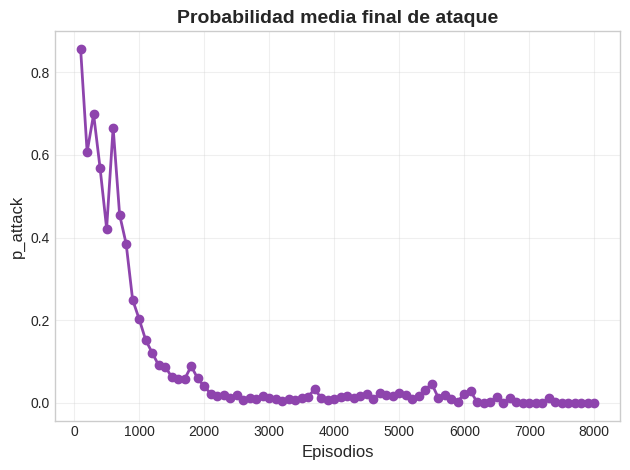

In [36]:
# Grafico de Probabilidad media final de ataque
plt.plot(
    episodes,
    mean_p_attack,
    marker="o",
    linewidth=2,
    markersize=6,
    color="#8e44ad",
)

plt.title("Probabilidad media final de ataque", fontsize=14, fontweight="bold")
plt.xlabel("Episodios", fontsize=12)
plt.ylabel("p_attack", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Evaluación de PPO

In [39]:
# Creamos un entorno vectorizado para evaluación
eval_env = DummyVecEnv([make_env])

# Cargamos la normalización del entorno usado en entrenamiento
eval_env = VecNormalize.load("../agents/ppo_attacker_multistep_vecnorm.pkl", eval_env)

# Desactivamos el entrenamiento, de manera que las estadísticas de normalización no se actualicen durante la evaluación 
eval_env.training = False

# Desactivamos la normalización de recompensas para la evaluación (cuando evaluamos queremos las recompensas reales)
eval_env.norm_reward = False

# Cargamos el modelo entrenado
model = PPO.load("../agents/ppo_attacker_multistep")

# Evaluamos el agente PPO atacante con 300 episodios
success_rate, mean_final_p = evaluate_sac_attacker(model, eval_env, n_episodes=300)

# Mostramos los resultados finales de la evaluación
print(f"Tasa de evasión (episodio completo, PPO): {success_rate*100:.3f}%")
print(f"Probabilidad media final de ataque (PPO): {mean_final_p*100:.3f}%")


/home/javil/miniconda3/envs/tesis-roberto/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Tasa de evasión (episodio completo, PPO): 100.000%
Probabilidad media final de ataque (PPO): 0.077%


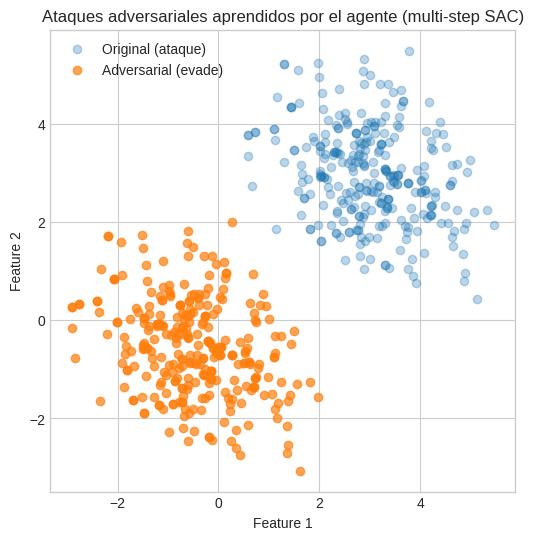

In [40]:
# Muestreamos 300 ataques adversariales generados por el agente PPO multi-step
xs_orig, xs_adv, successes = sample_adversarials_multistep(model, eval_env, n_episodes=300)

# Configuración de gráficos
plt.figure(figsize=(6, 6))

# Pintamos los ataques originales de color azul claro
plt.scatter(xs_orig[:, 0], xs_orig[:, 1], alpha=0.3, label="Original (ataque)")

# Pintamos los ataques adversariales que lograron evadir el detector de color naranja
mask_ok = successes == 1
plt.scatter(xs_adv[mask_ok, 0], xs_adv[mask_ok, 1], alpha=0.7, label="Adversarial (evade)")
plt.legend()
plt.grid(True)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Ataques adversariales aprendidos por el agente (multi-step SAC)")
plt.show()